In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd

import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})
def_color=plt.rcParams['axes.color_cycle']

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
#Get data from papers

#Gonzalez, J. G., Elizondo, G., Saldivar, D., Nanez, H., Todd, L. E., & Villarreal, J. Z. (1988). Pituitary gland growth during normal pregnancy: an in vivo study using magnetic resonance imaging. The American Journal of Medicine, 85(2), 217–220. Retrieved from http://www.ncbi.nlm.nih.gov/pubmed/3400697
gonzalez_pregnancy_week_mean=[0,8.5,21.3,36.5]
gonzalez_pregnancy_week_std=[0,2,3,3]
gonzalez_pituitary_vol_mm3_mean=[300,437,534,708]
gonzalez_pituitary_vol_mm3_std=[60,90,124,123]
gonzalez_pituitary_vol_num_subjects=[20,10,11,11]

#Elster, A. D., Sanders, T. G., Vines, F. S., & Chen, M. Y. (1991). Size and shape of the pituitary gland during pregnancy and post partum: measurement with MR imaging. Radiology, 181(2), 531–535. https://doi.org/10.1148/radiology.181.2.1924800
elster_pregnancy_week_mean=[0,10.5,30.5,40+0.5,40+13]
elster_pregnancy_week_std=[0,19/12**0.5,19/12**0.5,1/12**0.5,24/12**0.5]
elster_pituitary_height_mm_mean=[5.5,6.9,8.4,5.8,5.5]
elster_pituitary_height_mm_std=[6.6/12**0.5,3/12**0.5,3/12**0.5,5.3/12**0.5,5/12**0.5]
elster_pituitary_height_num_subjects=[30,8,9,12,15]

#I can get good dynamic data of CBG in Potter, J. M., Mueller, U. W., Hickman, P. E., & Michael, C. A. (1987). Corticosteroid binding globulin in normotensive and hypertensive human pregnancy. Clinical Science (London, England : 1979), 72(6), 725–735. Retrieved from http://www.ncbi.nlm.nih.gov/pubmed/3595077

jung_pregnancy_week_mean=[0,12,21,32,40+11]
jung_pregnancy_week_std=[0,0.4*20**0.5,0.4*20**0.5,0.4*20**0.5,0.3*20**0.5]
#Jung, C., Ho, J. T., Torpy, D. J., Rogers, A., Doogue, M., Lewis, J. G., … Inder, W. J. (2011). A Longitudinal Study of Plasma and Urinary Cortisol in Pregnancy and Postpartum. The Journal of Clinical Endocrinology & Metabolism, 96(5), 1533–1540. https://doi.org/10.1210/jc.2010-2395
jung_cortisol_nmolliter_mean=[364,577,878,1043,486]
jung_cortisol_nmolliter_std=[28*15**0.5,30*20**0.5,28*20**0.5,41*20**0.5,38*20**0.5]
jung_cortisol_num_subjects=[15,20,20,20,20]
#This is longitudinal study, besides this contains free cortisol, CBG, and urinary cortisol if needed.
#There is also figure with more detailed results of all women
#They measure plasma cortisol in two different methods

#Magiakou, M. A., Mastorakos, G., Rabin, D., Dubbert, B., Gold, P. W., & Chrousos, G. P. (1996). Hypothalamic corticotropin-releasing hormone suppression during the postpartum period: implications for the increase in psychiatric manifestations at this time. The Journal of Clinical Endocrinology & Metabolism, 81(5), 1912–1917. https://doi.org/10.1210/jcem.81.5.8626857
#This weird results show that ACTH response to CRH post-partum is blunted. How can we explain it?

#Labad, J., Vilella, E., Reynolds, R. M., Sans, T., Cavallé, P., Valero, J., … Gutiérrez-Zotes, A. (2011). Increased morning adrenocorticotrophin hormone (ACTH) levels in women with postpartum thoughts of harming the infant. Psychoneuroendocrinology, 36(6), 924–928. https://doi.org/10.1016/J.PSYNEUEN.2010.11.006
#Measurements of CRH,ACTH and cort in single timepoint
labad_pregnancy_week_mean=[40+2.0/7]
labad_pregnancy_CRH_pgml_mean=[144.1]
labad_pregnancy_CRH_pgml_std=[60.5]
labad_pregnancy_ACTH_pmolliter_mean=[5.09]
labad_pregnancy_ACTH_pmolliter_std=[2.98]
labad_pregnancy_cortisol_nmolliter_mean=[797.5]
labad_pregnancy_cortisol_nmolliter_std=[243.7]
labad_pregnancy_num_subjects=[115]



#Laatikainen, T., Virtanen, T., Räisänen, I., & Salminen, K. (1987). Immunoreactive corticotropin-releasing factor and corticotropin during pregnancy, labor and puerperium. Neuropeptides, 10(4), 343–353. https://doi.org/10.1016/S0143-4179(87)90101-6
laatikainen_pregnancy_week_mean=[9.5,13.5,17.5,21.5,25.5,29.5,33.5,37.5,40+2.5/7,40+10.5]
laatikainen_pregnancy_week_std=[2,2,2,2,2,2,2,2,2.0/7]
laatikainen_pregnancy_num_subjects=[14,6,12,5,12,7,7,11,10,10]
laatikainen_pregnancy_pCRH_pmolliter_mean=[2.9,2.9,5.2,10.2,14.6,32.8,63.6,187,5,3.7]
laatikainen_pregnancy_pCRH_pmolliter_std=[0.42,0.72,1.14,5.8,2,4.8,9.2,39,1.3,0.56]
laatikainen_pregnancy_ACTH_pmolliter_mean=[2.1,1.6,1.6,2.6,3.3,3.3,5.1,3]
laatikainen_pregnancy_ACTH_pmolliter_std=[0.36,0.43,0.01,0.26,0.34,0.22,0.74,1]
#Also note there that there is data on labor, in which ACTH increases significantly.

#Yim, I. S., Glynn, L. M., Dunkel-Schetter, C., Hobel, C. J., Chicz-DeMet, A., & Sandman, C. A. (2009). Risk of postpartum depressive symptoms with elevated corticotropin-releasing hormone in human pregnancy. Archives of General Psychiatry, 66(2), 162–169. https://doi.org/10.1001/archgenpsychiatry.2008.533
#There is data on CRH, I asked for the ACTH and cortisol measurements

#SASAKI, A., SHINKAWA, O., MARGIORIS, A. N., LIOTTA, A. S., SATO, S., MURAKAMI, O., … YOSHINAGA, K. (1987). Immunoreactive Corticotropin-Releasing Hormone in Human Plasma During Pregnancy, Labor, and Delivery*. The Journal of Clinical Endocrinology & Metabolism, 64(2), 224–229. https://doi.org/10.1210/jcem-64-2-224
#Measurement of placental and maternal CRH in pregnancy
#There is also data on delivery time


#GOLAND, R. S., WARDLAW, S. L., STARK, R. I., BROWN, L. S., & FRANTZ, A. G. (1986). High Levels of Corticotropin-Releasing Hormone Immunoactivity in Maternal and Fetal Plasma during Pregnancy*. The Journal of Clinical Endocrinology & Metabolism, 63(5), 1199–1203. https://doi.org/10.1210/jcem-63-5-1199
#Good CRH data in graph of tremesters (and 24h post partum)

#Kammerer, M., Taylor, A., & Glover, V. (2006). The HPA axis and perinatal depression: a hypothesis. Archives of Women’s Mental Health, 9(4), 187–196. https://doi.org/10.1007/s00737-006-0131-2
kammerer_pregnancy_week_mean=[0,30,37,40+1,40+8]
kammerer_pregnancy_cortisol_nmolliter_mean=[150,430,550,350,150]

#Dinç, H., Esen, F., Demirci, A., Sari, A., & Resit Gümele, H. (1998). Pituitary dimensions and volume measurements in pregnancy and post partum. MR assessment. Acta Radiologica (Stockholm, Sweden : 1987), 39(1), 64–69. Retrieved from http://www.ncbi.nlm.nih.gov/pubmed/9498873
dinc_pregnancy_week_mean=[0,18.5,30.2,40+1.5/7,40+4.4,40+17.4]
dinc_pregnancy_week_std=[0,2,3,1.5/7,4,8]
dinc_pituitary_vol1_mm3_mean=[385,514,718,847,569,385]
dinc_pituitary_vol1_mm3_std=[82,18,94,110,69,79]
dinc_pituitary_vol2_mm3_mean=[501,625,875,1103,692,497]
dinc_pituitary_vol2_mm3_std=[106,135,111,126,81,117]
dinc_pituitary_vol_num_subjects=[18,10,14,32,10,12]




#interpolation of all measured qunatities
x=np.linspace(0,60,61)
CRH_interp=np.interp(x,laatikainen_pregnancy_week_mean,np.array(laatikainen_pregnancy_pCRH_pmolliter_mean)/laatikainen_pregnancy_pCRH_pmolliter_mean[0])
ACTH_interp=np.interp(x,laatikainen_pregnancy_week_mean[:8],np.array(laatikainen_pregnancy_ACTH_pmolliter_mean)/laatikainen_pregnancy_ACTH_pmolliter_mean[0])
cortisol_interp=np.interp(x,jung_pregnancy_week_mean,np.array(jung_cortisol_nmolliter_mean)/jung_cortisol_nmolliter_mean[0])
pituitary_interp=np.interp(x,dinc_pregnancy_week_mean,np.array(dinc_pituitary_vol1_mm3_mean)/dinc_pituitary_vol1_mm3_mean[0])




In [3]:
def get5eqsparams(timescale='day'):
    #parameters are from the paper Mathematical modeling of the hypothalamic-pituitary-adrenal gland (HPA) axis, including hippocampal mechanisms.
    #Andersen M1, Vinther F, Ottesen JT.
    
    a1=0.1731 #[1/min]
    a2=0.0348 #[1/min]
    a3=0.009071 #[1/min]

    #mitosis every 63 days according to Nolan et al
    #aP=1/63/(60*24)
    aP=1/60/(60*24)
    
    
    # turnover of 60 days according to Kataoka et al
    aA=1/60/(60*24)

    
    #We normalize all means to 1, we therefore get
    b1=a1;b2=a2;b3=a3;bA=aA;bP=aP;
    
    res=np.array([a1,a2,a3,aA,aP,b1,b2,b3,bA,bP])
    
    if timescale=='hour':
        res=60*res
    
    if timescale=='day':
        res=24*60*res
    
    return res


def stiff_integration(f,y0,t):
    '''
    This is just another method to solve ODEs
    similar to Matlab's ode15
    '''
    ode15s = scipy.integrate.ode(f)#inputs should be t,y
    ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
    ode15s.set_initial_value(y0, 0)
    aaa=[]
    for i in range(len(t)):
        aaa.append(ode15s.integrate(ode15s.t+1))
    return np.array(aaa)



def simulatePlotModel(HPAmodel,ax,ver='hormones'):
    '''
    Simulation and plot of a given HPA model of pregnancy
    '''
    k=420
    t_seg=np.linspace(0,k-1,k)
    sol=stiff_integration(lambda t,y:HPAmodel(y,t),[1,1,1,1,1],t_seg)

    t=np.arange(sol.shape[0])/7
    if ver=='hormones':
        ax.plot(t,sol[:,0],'-',linewidth=3,color=def_color[2])
        ax.plot(t,sol[:,1],'-',linewidth=3,color=def_color[1])
        ax.plot(t,sol[:,2],'-',linewidth=3,color=def_color[0])
        ax.plot(t,sol[:,4],'-',linewidth=3,color=def_color[3])
        ax.legend(['CRH','ACTH','Cortisol','Pituitary'])
    else:
        ax.plot(t,sol[:,3],'--',linewidth=3,color=def_color[4])#adrenal
        ax.plot(t,sol[:,4],'-',linewidth=3,color=def_color[3])#pituitary
        ax.legend(['Adrenal','Pituitary'])
    ax.set_xlabel('Gestation week')
    ax.set_ylabel('Fold-change')
    ax.axvline(x=40,color='black')
    ax.set_xlim([0,60])
    return sol



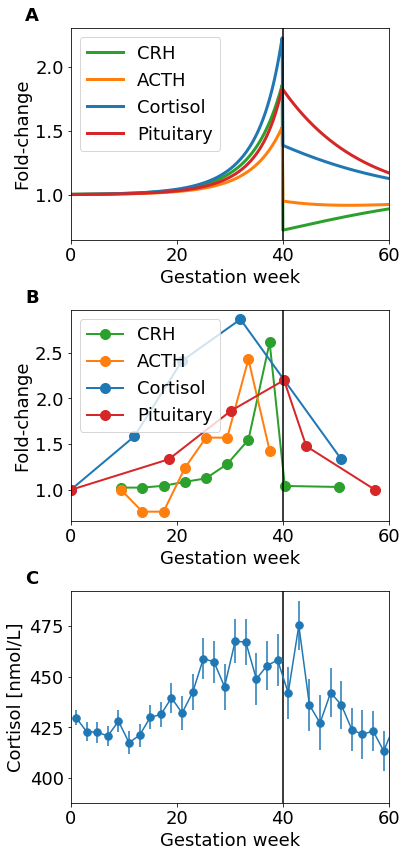

In [8]:
'''
Pregnancy figure for trophic CRH HPA model
(Figure 5 in paper 14.3.19 version)
'''
def HPASimulationCRH(y,t,timescale='day'):
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    [x1_,x2_,x3_,A_,P_]=y
    dy=np.empty(5)
    u_=1
    external=10**(t/110) #Nice results
    if t>280:
        external=0
    dy[0]= external+u_*b1_/x3_-a1_*x1_ #CRH
    dy[1]= b2_*x1_*P_/x3_-a2_*x2_ #ACTH
    dy[2]= b3_*x2_*A_-a3_*x3_ #Cortisol
    dy[3]= A_*(bA_*x2_-aA_) #Adrenal cells
    dy[4]= P_*(bP_*x1_-aP_) #Pituitary cells
    return dy

#Plot simulation of the model
fig,ax=plt.subplots(3,1,figsize=(6,12))
simulatePlotModel(HPASimulationCRH,ax[0])
ax[0].text(-0.1, 1.1, 'A', transform=ax[0].transAxes, fontweight='bold', va='top', ha='right')



#Plot data from paper
ax[1].plot(laatikainen_pregnancy_week_mean,1+np.array(laatikainen_pregnancy_pCRH_pmolliter_mean)/laatikainen_pregnancy_pCRH_pmolliter_mean[0]/40,'.-',linestyle='-',markersize=20,color=def_color[2],linewidth=2)
ax[1].plot(laatikainen_pregnancy_week_mean[:8],np.array(laatikainen_pregnancy_ACTH_pmolliter_mean)/laatikainen_pregnancy_ACTH_pmolliter_mean[0],'.-',linestyle='-',markersize=20,color=def_color[1],linewidth=2)
ax[1].plot(jung_pregnancy_week_mean,np.array(jung_cortisol_nmolliter_mean)/jung_cortisol_nmolliter_mean[0],'.-',linestyle='-',markersize=20,color=def_color[0],linewidth=2)
ax[1].plot(dinc_pregnancy_week_mean,np.array(dinc_pituitary_vol1_mm3_mean)/dinc_pituitary_vol1_mm3_mean[0],'.-',linestyle='-',markersize=20,color=def_color[3],linewidth=2)

ax[1].set_xlabel('Gestation week')
ax[1].set_ylabel('Fold-change')
ax[1].axvline(x=40,color='black')
ax[1].legend(['CRH','ACTH','Cortisol','Pituitary'])
ax[1].set_xlim([0,60])
ax[1].text(-0.1, 1.1, 'B', transform=ax[1].transAxes, fontweight='bold', va='top', ha='right')



#Plot cortisol data from Clalit
def get_week(x):
    return int(x.split(',')[0].split('[')[1])+1

dat=pd.read_csv('../data/pregnancy.CORTISOL_BLOOD.csv')
weeks=dat['week'].apply(lambda x: get_week(x))
ax[2].errorbar(weeks,np.array(dat['mean']),np.array(dat['sd']/dat['n']**0.5),marker='.',linestyle='-',color=def_color[0],markersize=15)
ax[2].set_xlabel('Gestation week')
ax[2].set_ylabel('Cortisol [nmol/L]')
ax[2].axvline(x=40,color='black')
ax[2].set_xlim([0,60])
ax[2].text(-0.1, 1.1, 'C', transform=ax[2].transAxes, fontweight='bold', va='top', ha='right')



fig.tight_layout()
plt.savefig('../figures/pregnancy_trophicCRH.pdf',bbox_inches='tight',dpi=600)

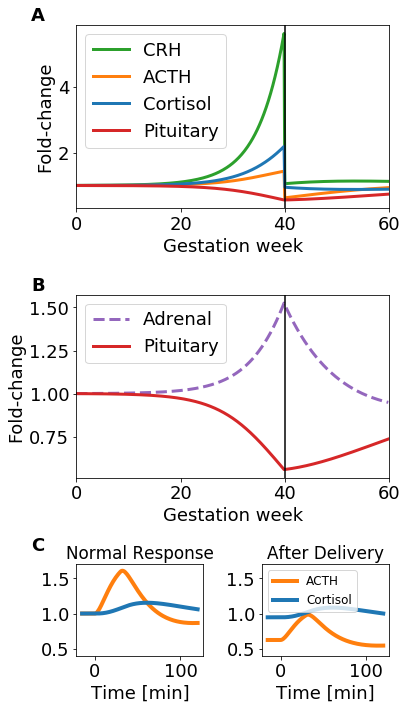

In [9]:
# Anti trophic cortisol SI figure (S8 in 14.3.19 version)

def HPASimulationCort(y,t,timescale='day'):
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    [x1_,x2_,x3_,A_,P_]=y
    dy=np.empty(5)
    u_=1
    external=10**(t/90)
    if t>280:
        external=0
    dy[0]= external+u_*b1_/x3_-a1_*x1_ #CRH
    dy[1]= b2_*x1_*P_/x3_-a2_*x2_ #ACTH
    dy[2]= b3_*x2_*A_-a3_*x3_ #Cortisol
    dy[3]= A_*(bA_*x2_-aA_) #Adrenal cells
    dy[4]= P_*(bP_/x3_-aP_) #Pituitary cells
    return dy


#fig,ax=plt.subplots(3,1,figsize=(6,12))

fig,axes=plt.subplots(3,2, figsize=(6,10),gridspec_kw = {'height_ratios':[2,2,1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
gs=matplotlib.gridspec.GridSpec(3,2,height_ratios=[2,2,1])


#Plot hormones of the anti-trophic cortisol model
axes[0][0].remove()
axes[0][1].remove()
ax1=fig.add_subplot(gs[0:1,0:2])
sol=simulatePlotModel(HPASimulationCort,ax1)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')

#Plot glands of the anti-trophic cortisol model
axes[1][0].remove()
axes[1][1].remove()
ax1=fig.add_subplot(gs[1:2,0:2])
simulatePlotModel(HPASimulationCort,ax1,ver='glands')
ax1.text(-0.1, 1.1, 'B', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')

#Plot the response to CRH pulse normal and after delivery, following Magikou et al

def HPAPulseSimulation(y,t,A_,P_,timescale='min'):
    '''Simulation of a CRH pulse'''
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    [x1_,x2_,x3_]=y
    dy=np.empty(3)
    if t>0 and t<30:
        ext_=0.2
    else:
        ext_=0
    dy[0]= ext_+b1_/x3_-a1_*x1_ #CRH
    dy[1]= b2_*x1_*P_/x3_-a2_*x2_ #ACTH
    dy[2]= b3_*x2_*A_-a3_*x3_ #Cortisol
    return dy

axes[2][0].text(-0.25, 1.3, 'C', transform=axes[2][0].transAxes, fontweight='bold', va='top', ha='right')

def plot_pulse(ax,A0,P0,title_text,with_legend=False):
    '''
    Plot the effect of CRH test on cortisol and ACTH at a given
    initial conditions of A0 and P0
    '''
    t_seg=np.linspace(-15,120,135)
    sol_pulse=odeint(lambda y,t:HPAPulseSimulation(y,t,A0,P0,timescale='min'),[A0**(-1/3)*P0**(-1/3),A0**(-2/3)*P0**(1/3),A0**(1/3)*P0**(1/3)],t_seg)
    ax.plot(t_seg,sol_pulse[:,1],'-',color=def_color[1],linewidth=4)
    ax.plot(t_seg,sol_pulse[:,2],color=def_color[0],linewidth=4)
    ax.set_ylim([0.4,1.7])
    if with_legend:
        ax.legend(['ACTH','Cortisol'],loc=2, prop={'size': 12})
    ax.set_title(title_text)
    ax.set_xlabel('Time [min]')

matplotlib.rcParams.update({'font.size': 14})


plot_pulse(axes[2][0],1,1,'Normal Response')
plot_pulse(axes[2][1],sol[280,3],sol[280+0,4],'After Delivery',True)

matplotlib.rcParams.update({'font.size': 18})


fig.tight_layout()

plt.savefig('../figures/pregnancy_antutrophic_cort.pdf',bbox_inches='tight',dpi=600)